# **CS 181 HW5 Problem 2**
---

#### Initialize data:

In [4]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)  # download MNIST
N = 6000 

x = mnist_trainset.data[:N]  # select N datapoints
x = x.flatten(1)             # flatten the images
x = x.float()                # convert pixels from uint8 to float
# x = x.numpy()              # uncomment to use numpy (optional)

In [3]:
x.shape[0]

6000

#### **Todo:** implement PCA

*Hint: see `.linalg.svd()`*

In [17]:
def pca(x, n_comps=500):
    x_std = x - x.mean(0)
    _, top_eigvals, top_pcomps = np.linalg.svd(x_std.T@x_std)

    # top_pcomps = 'not implemented'
    print(top_eigvals.shape)
    print (f"Variance explained by Top 500: {np.sum(top_eigvals[:n_comps])} = {np.sum(top_eigvals[:n_comps])/np.sum(top_eigvals):.2%} of the total")
    return top_eigvals[:n_comps], top_pcomps[:n_comps]

#### **Todo:** calculate cumulative fraction of variance

*Hint: see `.cumsum()`*

In [9]:
def calc_cfvs(eigvals):
    cum_frac_vars = np.cumsum(eigvals)/np.sum(eigvals)
    return cum_frac_vars

#### **Todo:** calculate mean squared L2 norm reconstruction loss

In [10]:
def calc_errs(x, pcomps):
    res_mean = x - x.mean(0)
    err_mean = torch.mean(torch.sum(res_mean**2, dim=1))

    z = res_mean @ (pcomps[:10].T)
    res_pcomp = res_mean - z @ pcomps[:10]
    err_pcomp = torch.mean(torch.sum(res_pcomp**2, dim = 1))
    return err_mean, err_pcomp

#### Plot and print errors:

In [11]:
def plot_pic(pic, ax, title=''):
    x = pic.reshape(28, 28)
    ax.imshow(x, cmap='binary')
    ax.set_title(title)
    ax.axis('off')

def make_plots(eigvals, cfvs, x_mean, pcomps):
    # plot eigenvals and cfvs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(eigvals, color='tomato')
    ax1.set_title('Eigenvalues')
    ax2.plot(cfvs, color='tomato')
    ax2.set_title('CFVs')
    fig.savefig('p2_cfvs.pdf')

    # plot mean
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_pic(x_mean, ax, title='Mean')
    fig.savefig('p2_mean.pdf')

    # plot top 10 pcomps
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        plot_pic(pcomps[i], axes.flat[i], title=f'PC index {i}')
    fig.savefig('p2_pcomps.pdf')

(784,)
Variance explained by Top 500: 20603731968.0 = 99.94% of the total
Reconstruction error (using mean): 3.436023e+06
Reconstruction error (using mean and top 10 pcomps): 1.731315e+06


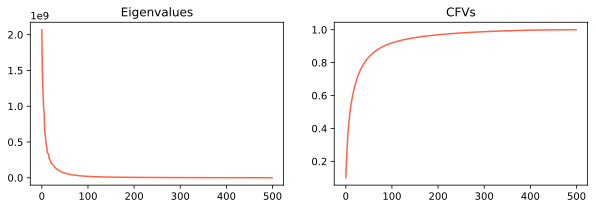

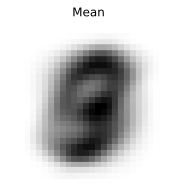

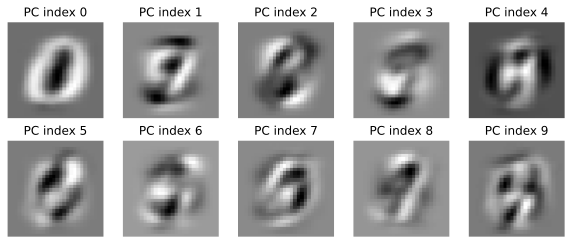

In [18]:
# do PCA
eigvals, pcomps = pca(x)

# calculate CFVs
fcvs = calc_cfvs(eigvals)

# print errors
err_mean, err_pcomp = calc_errs(x, pcomps)
print(f'Reconstruction error (using mean): {err_mean:3e}')
print(f'Reconstruction error (using mean and top 10 pcomps): {err_pcomp:3e}')

# make plots
make_plots(eigvals, fcvs, x.mean(0), pcomps)


In [36]:
## implement k means

class KMeans:
    def __init__(self, K = 10):
        super().__init__()
        self.K = K

    def dist(a, b):
        return np.sum((a-b)**2, axis = -1)

    def fit(self, x):
        x = np.array(x)
        self.x = x
        self.N = x.shape[0]
        self.D = x.shape[1]
        self.r = np.random.randint(self.K, size=(self.N,))

        self.mu = np.zeros((self.K, self.D))

        # fit
        new_r = np.zeros_like(self.r)
        while True:
            for k in range(self.K):
                self.mu[k] = np.mean(x[self.r == k], axis=0)
            for i in range(self.N):
                new_r[i] = np.argmin(KMeans.dist(x[i], self.mu))
            if not np.any(new_r != self.r):
                break
            self.r, new_r = new_r, self.r
            
    def get_clusters(self):
        return self.mu

    def get_loss(self):
        return np.mean(np.sum((self.x - self.mu[self.r])**2, axis = -1))
        


In [35]:
np.arange(9).reshape((3, 3))[np.ones((3,)).astype(int)]

array([[3, 4, 5],
       [3, 4, 5],
       [3, 4, 5]])

 2.509914e+06


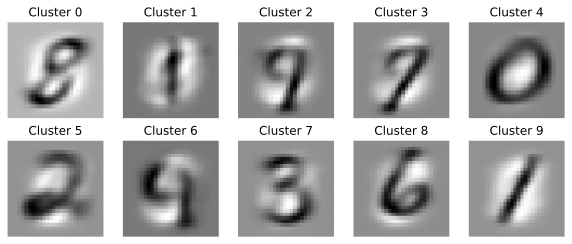

In [38]:
k_means = KMeans(K = 10)
k_means.fit(x - x.mean(0))
clusters = k_means.get_clusters()
print(f"{k_means.get_loss(): 3e}")

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    plot_pic(clusters[i], axes.flat[i], title=f'Cluster {i}')
fig.savefig('p2_kmeans.pdf')